# Stanford CME 241 (Winter 2025) - Assignment 3

**Due: Sunday, February 23 @ 11:59 PM PST on Gradescope.**

Assignment instructions:
- Make sure each of the subquestions have answers
- Ensure that group members indicate which problems they're in charge of
- Show work and walk through your thought process where applicable
- Empty code blocks are for your use, so feel free to create more under each section as needed
- Document code with light comments (i.e. 'this function handles visualization')

Submission instructions:
- When complete, fill out your publicly available GitHub repo file URL and group members below, then export or print this .ipynb file to PDF and upload the PDF to Gradescope.

*Link to this ipynb file in your public GitHub repo (replace below URL with yours):* 

https://github.com/my-username/my-repo/assignment-file-name.ipynb

*Group members (replace below names with people in your group):* 
- Junyoung Jeong
- Andrew Sung
- Elliot Porter

## Imports

In [14]:
import numpy as np
import math
from pprint import pprint
import matplotlib.pyplot as plt
from dataclasses import dataclass
from scipy.optimize import minimize_scalar
from typing import Iterable, Iterator, Mapping, TypeVar, Callable, Sequence, Tuple, Dict
from rl.distribution import Categorical
from rl.markov_process import FiniteMarkovProcess, FiniteMarkovRewardProcess
from rl.markov_decision_process import FiniteMarkovDecisionProcess
from rl.policy import FiniteDeterministicPolicy
from rl.chapter10.prediction_utils import compare_td_and_mc
X = TypeVar('X')
S = TypeVar('S')

## Question 1: Milk Vendor Optimization Problem (Led by Junyoung)

You are a milk vendor and your task is to bring to your store a supply (denoted $S \in \mathbb{R}$) of milk volume in the morning that will give you the best profits. You know that the demand for milk throughout the course of the day is a probability distribution function $f$ (for mathematical convenience, assume people can buy milk in volumes that are real numbers, hence milk demand $x \in \mathbb{R}$ is a continuous variable with a probability density function). 

For every extra gallon of milk you carry at the end of the day (supply $S$ exceeds random demand $x$), you incur a cost of $h$ (effectively the wasteful purchases amounting to the difference between your purchase price and the end-of-day discount disposal price since you are not allowed to sell the same milk the next day). For every gallon of milk that a customer demands that you don’t carry (random demand $x$ exceeds supply $S$), you incur a cost of $p$ (effectively the missed sales revenue amounting to the difference between your sales price and purchase price). 

Your task is to identify the optimal supply $S$ that minimizes your **Expected Cost** $g(S)$, given by:

$$
g_1(S) = \mathbb{E}[\max(x - S, 0)] = \int_{S}^{\infty} (x - S) \cdot f(x) \, dx
$$

$$
g_2(S) = \mathbb{E}[\max(S - x, 0)] = \int_{-\infty}^{S} (S - x) \cdot f(x) \, dx
$$

$$
g(S) = p \cdot g_1(S) + h \cdot g_2(S)
$$

---

### Part (A): Analytical Optimization

1. **Derive the first-order condition (FOC)** for minimizing the expected cost $g(S)$.
2. **Solve the FOC** to express the optimal supply $S^*$ in terms of the given parameters: $p$, $h$, and the demand distribution $f(x)$. (*Hint*: Pay attention to the balance between the costs of overstocking and understocking)

3. **Interpretation**: Provide an interpretation of the condition you derived. What does the balance between $p$ and $h$ imply about the optimal supply $S^*$?

---

### Part (B): Special Case Analysis

1. Consider the case where the demand $x$ follows an **exponential distribution** with parameter $\lambda > 0$. That is, $f(x) = \lambda e^{-\lambda x}$ for $x \geq 0$.
    - Derive an explicit expression for the optimal supply $S^*$.
    
2. Consider the case where the demand $x$ follows a **normal distribution** with mean $\mu$ and variance $\sigma^2$, i.e., $x \sim \mathcal{N}(\mu, \sigma^2)$. 
    - Set up the integral for $g(S)$ and describe how it relates to the **cumulative distribution function (CDF)** of the normal distribution.
    - Provide an interpretation of how changes in $\mu$ and $\sigma$ influence the optimal $S^*$. 

---

### Part (C): Framing as a Financial Options Problem

1. Frame the milk vendor’s problem as a **portfolio of call and put options**:
    - Identify the analog of the “strike price” and “underlying asset.”
    - Explain which part of the cost function $g_1(S)$ or $g_2(S)$ corresponds to a call option and which part to a put option.
    - What do $p$ and $h$ represent in this options framework?

2. Explain how this framing could be used to derive the optimal supply $S^*$ if solved using financial engineering concepts.

---

### Part (D): Numerical Solution and Simulation

1. **Numerical Solution**: Write a Python function that numerically estimates the optimal $S^*$ using an iterative search or numerical optimization method. 

2. **Simulation**: Generate random samples of milk demand from an exponential distribution and simulate the total costs for different values of $S$. Plot the costs against $S$ and visually identify the optimal $S$.

### Part (A) Answer

1. Apply the Leibniz rule to $g_1(s)$ and $g_2(s)$. To apply this rule, it is necessary to assume that $f(x)$ is continuously differentiable in $x$. Furthermore, I assume that $f(x)$ does not have fat tails.
\begin{align}
\frac{d}{d S}\left[\int_{S}^{\infty} (x - S) \cdot f(x) \, dx\right] 
&= (\infty - S) f(\infty)\cdot 0 - (S-S) f(S) \cdot 1 + \int_{S}^{\infty} - f(x) \, dx\\
&= \int_{S}^{\infty} - f(x) \, dx
\end{align}

\begin{align}
\frac{d}{d S}\left[\int_{-\infty}^{S} (S - x) \cdot f(x) \, dx\right ]
&= (S-S)f(S)\cdot 0 - (-\infty - S) f(-\infty) \cdot 1 + \int_{-\infty}^{S} f(x) \, dx\\
&= \int_{-\infty}^{S} f(x) \, dx
\end{align}

Combining these derivatives yields the first order condition for the objective.
$$
0 = p \cdot \int_{S}^{\infty} - f(x) \, dx + h \cdot \int_{-\infty}^{S} f(x) \, dx
$$

2. Let $F(s) = \int_{-\infty}^(s) f(s) \, ds$. Note that since $F(s)$ is a cumulative distribution function $F(\infty) = 1$. Substituting this expression into our FOC yields the following.
$$
0 = p \cdot (1- F(S)) + h \cdot F(S)
$$
Thus the optimal $S$, which we will denote $S^*$ can be characterized as the following.
$$
S^* = F^{-1}(\frac{p}{p+h})
$$
where $F^{-1}(\cdot)$ is the inverse function of $F(\cdot)$.

3. We can interpret this condition as picking $S$ such that the the probability of having insufficient supply is equal to $\frac{p}{p+h}$. 

### Part (B) Answer

1. Now suppose that demand $x$ follows an **exponential distribution** with parameter $\lambda > 0$. This implies $f(x) = \lambda e^{-\lambda x}$ for $x \geq 0$ and $0. for all $x < 0$. Thus we can write $F(x) = 1- e^{-\lambda x}$. 
$$
S^* = F^{-1}(\frac{p}{p+h}) = - \frac{1}{\lambda}\ln(1 - \frac{p}{p+h}) = - \frac{1}{\lambda}(\ln(h) - \ln(p+h))
$$
    
2. Now suppose that demand $x$ follows a **normal distribution** with mean $\mu$ and variance $\sigma^2$, i.e., $x \sim \mathcal{N}(\mu, \sigma^2)$. 

    - We can write $g(S)$ in terms of the cumulative distribution function of the normal distribution $\Phi(S; \mu, \sigma^2)$ as follows. 
    \begin{align}
    g(S) 
    &= p \cdot \int_{S}^{\infty} (x - S) \cdot f(x) \, dx + h \cdot \int_{-\infty}^{S} (S - x) \cdot f(x) \, dx\\
    &= p \cdot \int_{S}^{\infty} x \cdot f(x)\, dx - p \cdot \int_{S}^{\infty} S \cdot f(x)\, dx + h \cdot \int_{-\infty}^{S} S \cdot f(x) \, dx - h \cdot \int_{-\infty}^{S} x \cdot f(x) \, dx\\
    &= p \mathbb{E}[x] - (p+h) \int_{-\infty}^{S} x \cdot f(x)\, dx - S (p + (h-p) \Phi(S; \mu, \sigma^2)) \\
    &= p \mathbb{E}[x] - (p+h) \mathbb{E}[x|x<S] - S p + S (p-h) \Phi(S; \mu, \sigma^2) \\
    \end{align}
    We see that for any positive fixed $S$, $g(S)$ is increasing in $\Phi(\cdot)$ if $p-h$ is positive and decreasing in $\Phi(\cdot)$ if $p-h$ is negative. This reverses if $S$ is negative.

    - Go back to our expression for the optimal $S$.
    $$
    \Phi(S^*,\mu,\sigma^2) = \frac{p}{p+h}
    $$
    Increasing $\mu$ decreases $\Phi(S;\mu,\sigma^2)$ for all $S$ - so the optimum $S$ must be increased in order to hit the ratio $\frac{p}{p+h}$. Increasing $\sigma^2$ makes $\Phi(\cdot)$ increase more slowly. By the symmetry of the normal distribution around the mean, for any $s^2 > \sigma^2$ we will have $\Phi(S,\mu,\sigma^2) > \Phi(S,\mu,s^2)$ for $S < \mu$ and vice versa for $S > \mu$. As a result, the impact on the optimal $S^*$ is unclear and will depend on $p$ and $h$.


### Part (C) Answer

1. We can frame the milk vendor's problem as a portfolio of options.
    -  The underlying asset is demand $x$, and the milk vendor holds options with a strike price at the supply $S$ that they hold.
    - The cost $g_1(S)$ is positive when demand is too high - so it is equivalent to shorting a call option on demand. The cost $g_2(S)$ is positive when demand is too low - so it is equivalent to shorting a put option on demand. 
    - $p$ and $h$ represent the position on these options the milk vendor is holding.

2. With this framing, the milk vendor's problem is equivalent to setting the optimal strike price when given a fixed position of options. The math to do this is much the same as what we have done in the previous parts of this problem. The insights from financial engineering are probably much more useful if the milk vendor is solving some type of dynamic stocking problem, where they can order milk at fixed frequencies and need to solve the dynamic stocking problem. Then we can apply much of the same lessons from dynamic programming or RL to this problem. 

### Part (D) Answer

In [15]:
from scipy import integrate

'''
### Part (D): Numerical Solution and Simulation

fill in the code below, and then run the code in the next cell for the simulation
'''

# simulation parameters
p = 5  # Cost of understocking (per unit)
h = 2  # Cost of overstocking (per unit)
lambda_param = 1.0  # Parameter for exponential distribution

# Probability density function for demand
def demand_pdf(x):
    return (lambda_param * np.exp(-lambda_param * x))

# Cumulative distribution function for demand
def demand_cdf(x):
    return (1-np.exp(-lambda_param * x))

# Expected cost function g(S)
def expected_cost(S):
    # g1(S): Understocking cost
    g1 = p*(integrate.quad(lambda x: x*demand_pdf(x), S, np.inf)[0] - S * (1-demand_cdf(S)))

    # g2(S): Overstocking cost (integral using CDF)
    g2 = h*(S * demand_cdf(S) - integrate.quad(lambda x: x*demand_pdf(x), 0, S)[0])
    
    return g1 + g2

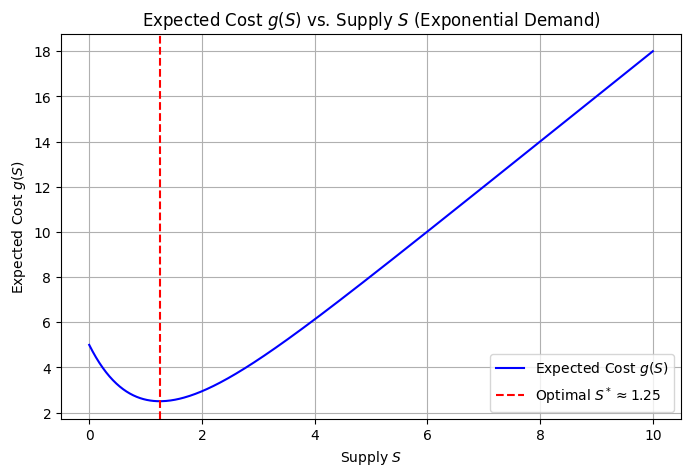

np.float64(1.2527630511681802)

In [16]:
result = minimize_scalar(expected_cost, bounds=(0, 10), method='bounded')
optimal_S = result.x

# Simulation of costs
S_values = np.linspace(0, 10, 500)
costs = [expected_cost(S) for S in S_values]

# Plotting the costs against S
plt.figure(figsize=(8, 5))
plt.plot(S_values, costs, label="Expected Cost $g(S)$", color='blue')
plt.axvline(optimal_S, color='red', linestyle='--', label=f"Optimal $S^* \\approx {optimal_S:.2f}$")
plt.xlabel("Supply $S$")
plt.ylabel("Expected Cost $g(S)$")
plt.title("Expected Cost $g(S)$ vs. Supply $S$ (Exponential Demand)")
plt.legend()
plt.grid(True)
plt.show()

optimal_S

## Question 2: Optimal Bank Cash Management with Risky Investments and Penalties (Led By: Junyoung)

Assume you are the owner of a bank where customers come in randomly every day to make cash deposits and to withdraw cash from their accounts. At the end of each day, you can borrow (from another bank, without transaction costs) any cash amount $y > 0$ at a constant daily interest rate $R$, meaning you will need to pay back a cash amount of $y(1 + R)$ at the end of the next day. Also, at the end of each day, you can invest a portion of your bank’s cash in a risky (high return, high risk) asset. Assume you can change the amount of your investment in the risky asset each day, with no transaction costs (this is your mechanism to turn any amount of cash into risky investment or vice-versa).

A key point here is that once you make a decision to invest a portion of your cash in the risky asset at the end of a day, you will not have access to this invested amount as cash that otherwise could have been made available to customers who come in the next day for withdrawals. More importantly, if the cash amount $c$ in your bank at the start of a day is less than $C$, the banking regulator will make you pay a penalty of $K \cdot \cot\left( \frac{\pi c}{2C} \right)$ (for a given constant $K > 0$).

For convenience, we make the following assumptions:
- Assume that the borrowing and investing is constrained so that we end the day (after borrowing and investing) with positive cash ($c > 0$) and that any amount of regulator penalty can be immediately paid (meaning $c \geq K \cdot \cot\left( \frac{\pi c}{2C} \right)$ when $c \leq C$).
- Assume that the deposit rate customers earn is so small that it can be ignored.
- Assume for convenience that the first half of the day is reserved for only depositing money and the second half of the day is reserved for only withdrawal requests.
- Assume that if you do not have sufficient cash to fulfill a customer withdrawal request, you ask the customer to make the withdrawal request again the next day.
- Assume all quantities are continuous variables.

---

### Part (A): MDP Modeling

Model the bank’s problem as a **Markov Decision Process (MDP)** with the goal of maximizing the **Expected Utility of assets less liabilities** at the end of a $T$-day horizon, conditional on any current situation of assets and liabilities.

1. **State Space**: Define the possible states of the system.
2. **Action Space**: Specify the possible actions available to the bank at each state.
3. **Transition Function**: Describe how the state evolves based on the current state and the chosen action.
4. **Reward Function**: Specify the reward structure that incentivizes optimal behavior.

*Note*: Be very careful with your notation; ensure that every subscript, index, superscript, prime, etc. is properly defined and necessary. There are a lot of variables at play, so everything must be properly defined or points will be deducted.

---

### Part (B): Reinforcement Learning Approach

In a practical setting, we do not know the exact probability distributions of the customer deposits and withdrawals. Neither do we know the exact stochastic process of the risky asset. But assume we have access to a large set of historical data detailing daily customer deposits and withdrawal requests, as well as daily historical market valuations of the risky asset. Assume we also have data on new customers as well as leaving customers (sometimes due to their withdrawal requests not being satisfied promptly).

Describe your approach to solving this problem with **Reinforcement Learning** by using the historical data described above.

1. Specify which **Reinforcement Learning algorithm** you would use, including any customizations for this problem.
2. Provide sufficient detail that will enable a programmer with knowledge of RL to implement your ideas.

*Note*: You are not expected to write any code for this part.

### Part (A) Answer

First, I rewrite the problem in more precise notation. A time period $t$ consists of the following stages for all $t \in [0,T-1] \cap \mathbb{N}$.
1. The end of the day after the bank has paid off all of its loans, and received the returns on its risky investment. I will denote the cash that the bank holds at this moment as its assets $A_t$. I also denote the total deposits at the bank at this moment as $\Delta_t$ - the total amount the bank owes to its customers. 
2. The bank chooses its portfolio for the next day by borrowing $y_t \geq 0$ and investing $x_t \geq 0$ into the risky asset. The bank also holds $c_t > 0$ in cash. 
    -  I assume the risky asset has returns $\theta_t$ with distribution defined by the cumulative distribution function $F^\theta(\theta)$ which is bounded below at $0$. This assumption implies the bank can not lose more than its investment into the risky asset (limited liability).
    - I also assume the bank can not short the risky asset. 
3. Customers come in to deposit their money. I will denote the total deposits gained for the day as $D_t \geq 0$. 
    - I assume $\tilde{D}_t$ has distribution defined by the cumulative distribution function $F^D(D)$.
4. Customers come in to withdraw their money where $W_t \geq 0$ will denote the total withdrawals in the day. 
    - I assume $\tilde{W}_t$ has distribution defined by the cumulative distribution function $F^W(W; \Delta)$.
    - If the bank has insufficent cash to cover the withdrawal, the customer will come again the next day. Let the amount of deposits demanded by customers due to customers being turned away in the previous day be denoted $w_t$. 
    - Note that the distribution is a function of $\Delta$ because the support of $F^W$ is bounded above at $\Delta$ since customers can not withdraw more than the quantity deposited. 
    - Note that this for simplicity, I assume that the distribution of customers coming to deposit and withdraw remains consistent over times and states. This may not be the case in reality as rejecting large withdrawal requests could trigger a bank run which may change the distribution of deposits over time ands states. This could be amended by allowing for the distributions $F^D$ and $F^W$ to be functions of additional variables that would then have to be included as state variables.
5. Finally, the end of the day comes, and the bank repays the amount borrowed with interest $y_t (1+R)$, receives the return on its risky investment $x_t \cdot \theta_t$, and pays any penalties it owes.
This concludes time period $t$. The terminal period $T$ will have the bank owner return all of the deposits $\Delta_T$ and consume the remaining balance. Under the way we have described the problem, this will exactly correspond to assets less liabilities since the bank will have already paid off its loans, received the returns on its risky investment, and paid any penalties at the end of period $T-1$. I maintain the assumption that the bank will need to have a positive cash balance on the final day - so all depositor's are guaranteed to have their funds returned. 

Now to answer the question:
1. The state variables are the assets of the bank $A_t \in (0, \infty)$, the total deposits the bank owes customers $\Delta_t \in [0,\infty)$, the total amount of withdrawals rejected on the previous day $w_t \in [0, \infty)$, and the time $t$. The game terminates at time $T$, so any state with time $t=T$ is a terminal state. 

2. The bank has two actions $y_t \in \mathbb{R}_+$ and $x_t \in \mathbb{R}_+$ where $y_t$ is the amount to borrow and $x_t$ is the amount to invest in the risky asset. The amount of cash the bank holds in reserve $c_t$ can be backed out as $c_t = A_t + y_t - x_t$. The bank's choice of $y_t$ and $x_t$ is constrained such that $c_t \geq K \cdot \cot\left(\frac{\pi c_t}{2C}\right)$ if $c_t < C$.

3. Given assets $A_t$ at beginning of period $t$, suppose the bank chooses to borrow $y_t$ and invest $x_t$ in the risky asset. The state variable for time increments by $1$ and the other state variables follow the laws of motion detailed below.
    $$
        A_{t+1} = c_t - \mathbb{I}[c_t < C] \cdot K \cdot \cot\left( \frac{\pi c_t}{2C} \right) + D_t - \max\{W_t + w_t, c_t - \mathbb{I}[c_t < C] \cdot K \cdot \cot\left( \frac{\pi c_t}{2C} \right)+ D_t\} - y_t(1+R) + x_t \theta_t\\
        \Delta_{t+1} = \Delta_t + D_t - (W_t-w_t)\\
        w_{t+1} = \max\{0, W_t + w_t - c_t + y_t + D_t\}
    $$
    where $\mathbb{I}$ is the indicator function. 

4. I assume that the bank is maximizing the expected utility of assets less liabilities at the end of day $T$.
    $$
    U\left(A_T - \Delta_T\right)
    $$
    I think there are two choices in how to structure the rewards. You can let the reward only be the termination value of the game, $A_T - \Delta_T$ and let there be no immediate rewards. 

    Alternatively, the algorithm probably performs better if you give it more immediate rewards. The bank's net assets will change every day, and this change will eventually be reflected in the termination value. To see this:
    $$
    A_T - \Delta_T = (A_T - A_{T-1})+ A_{T-1} - (\Delta_T - \Delta_{T-1}) + \Delta_{T-1} = \cdots
    $$
    Extending this logic shows that summing the change in the net assets every day will yield the final net assets number $A_T - \Delta_T$. Therefore, we can set the reward function to be the daily change in net assets.
    $$
    R_t = (A_t - \Delta_t) - (A_{t-1} - \Delta_{t-1})
    $$

Therefore we can write the Bellman for this problem as follows.
\begin{align}
    V(A_t,\Delta_t, w_t, t) = \max\limits_{y_t,x_t} (A_t - \Delta_t) - (A_{t-1} - \Delta_{t-1}) + \mathbb{E}\left[V(A_{t+1}, \Delta_{t+1}, w_{t+1}, t+1)| y_t, x_t\right]
\end{align}
where our variables follow the laws of motion described above. 

### Part (B) Answer

Given that in the real world we do not know the exact distributions of customer deposits, withdrawals or the returns of the risky asset ($F^D,F^W,F^\theta$ described in the model above), reinforcement learning is a reasonable way to attempt to solve this problem. 

With access to historical data on realizations of customer deposits, withdrawals, and returns, we can generate a sampling model of the transition models and transition samples. Furthermore, we can add the data on new and leaving customers as well to better estimate the sampling model on how actions affect the distribution of future deposits and withdrawals (i.e. we can think of number of customers as a state variable as well). I will provide more explicit details on how to construct these items below. Note that we can think about this as either simulating the environment (estimating the transition probabilities) or just estimating the distribution of values as a function of the states using our data. 

1. I will describe how Deep Q learning (by which I mean temporal-difference with batch updating and experience-replay) can be used to solve this problem. Deep Q learning is a good fit because it addresses the following problems of using a stream of historical data to predict bank returns.
    - Unless the bank has an explicit time horizon in mind, there is no terminal state other than bankruptcy - and this is not something the bank would be able to experiment with. Hence it is not possible to provide full episodic traces, meaning that we can not use a MC method. 
    - There is high autocorrelation over time in the flow of deposits, withdrawals, and returns. The experience-replay component of Deep Q learning helps address this issue by randomly sampling from the data bank.
    - Even though we have many data points, there are often rare events in the economy that can significantly change the bank's value function. This is an issue that is somewhat addressed by batch updating and experience-replay as it prevents the algorithm from overupdating on the present (i.e. the economy is good for a long stretch of time and biases the algorithm towards a good economy, but experience-replay helps prevent this by sampling from previous bad stretches of the economy and batch updating prevents the algorithm from updating only on recent data.)
2. We can implement this algorithm in the following steps (very closely following the description in the slides for batch RL)
    - If we closely followed the model described in part 1, we would use the total assets of the bank, the deferred withdrawals and the time remaining as the state variables. However, there are a few issues translating this into a real world implementation.
        - What time would we want to set as the termination time? One simple solution could be setting $T$ to 20 years or somethign relatively far away. More involved ways to approach this problem is to instead assume an infinite horizon and have fixed dividends paid out from the net assets of the bank that the bank's owners can immediately consume. Then the reward function would be to maximize the discounted sum of these dividends rather than the net assets at time $T$. 
        - It is likely that there are way more states that are important to this problem in the real world than the stylized model of part 1. For example, deposits, withdrawals, and returns are likely to be tightly related to a wide variety of macroeconomic factors. Therefore, it may be more realistic to simply throw the kitchen sink as the state variable - as even if you don't have data that explicitly captures a macroeconomic factor - you may be able to essentially recreate it using some combination of your data streams.
    Thus a more realistic approach may be to set the state variable $S_t$ as the bank's assets, a few averages of deposits, withdrawals and returns of the risky asset over various time horizons (i.e. previous day, week, month, year), as well as time left until some arbitrary deadline. We could also drop the deadline entirely and simply use the reward function of the change in net assets described in the previous part. 

    However, since we have already fixed ideas in the previous part of the question, I will maintain the same notation. 
    - Given a state $S_t = (A_t, \Delta_t, w_t, t)$ - take the action $A_t = (y_t,x_t)$ (amount of reserves $y_t$ and risky loan portfolio $x_t$) following an $\epsilon$-greedy policy from the $Q$ network. The initial $Q$ values can be any arbitrary guess. These actions are ways to sample the state space.
    - Observe the atomic experiences of a given state $S_t$, as well as the received the reward $A_t - \Delta_t - (A_{t-1} - \Delta_{t-1})$ and the following state $S_{t+1}$.
    - Store these atomic experiences in replay memory
    - Sample the replay memory to generate a batch to update the $Q$ network parameters
    - Update the $Q$ network as follows:
    $$
    \text{Change in } \omega = \alpha \cdot \sum\limits_{i} (R_i + \gamma \cdot \max\limits_{A_i'} Q(S_i', A_i'; \omega^{-}) - Q(S_i, A_i; \omega)) \cdot \nabla_\omega Q(S_i, A_i, \omega)
    $$
    where the prime indicates the variable in the next period and $w^{-}$ indicates the "frozen" parameters for the $Q$ network that are not updated.

## Question 3: Career Optimization (Led By: Junyoung)

Imagine you live in a world where every job is an hourly-wage job. You have $H$ available hours in a day (for some fixed $H \in \mathbb{Z}^+$), and each morning when you leave your house, you can decide to split those $H$ hours into:

- Hours spent on learning to get better at your current job (call it $l \in \mathbb{Z}_{\geq 0}$),
- Hours spent on searching for another job (call it $s \in \mathbb{Z}_{\geq 0}$), and
- Remaining $H - l - s$ hours spent on actually working on your current job.

If your job currently pays you at an hourly-wage of $w$ dollars, then at the end of that day, you will be given a cash amount of $w \cdot (H - l - s)$ dollars. We assume that any hourly-wage $w$ in our world is an integer in the finite set $\{1, 2, \dots, W\}$ for some fixed $W \in \mathbb{Z}^+$.

Each employer has a wage model such that if you spend $l$ hours on learning on a given day where your hourly-wage was $w$, then the employer sends you an email the next morning with that new day’s hourly-wage of:  
$$\min(w + x, W)$$  
where $x$ is a Poisson random variable with mean $\alpha \cdot l$ for some fixed $\alpha \in \mathbb{R}^+$.

Each morning, with probability $\frac{\beta s}{H}$ for some fixed $\beta \in [0, 1]$, you will receive an email from another employer with a job-offer with hourly-wage of  
$$\min(w + 1, W)$$  
where $w$ was the hourly wage of the job you were on the previous day and $s$ is the number of hours you spent on job-search the previous day.

You read all your emails before you leave your house in the morning. If another job is offered to you and if the hourly-wage of that job is greater than your current employer’s hourly-wage stated in that morning’s email, then you accept the other job. Otherwise, you continue in your current job. Whichever job you decide to do, each morning when you leave your house, you decide how to split the $H$ hours of that day into learning hours, job-searching hours, and working hours.

Your goal is to maximize the **Expected (Discounted) Wages** earned over an infinite horizon (assume you never age and will live infinitely). The daily discount factor is a fixed $0 < \gamma < 1$.

---

### Part (A): MDP Modeling

With proper mathematical notation, model this as a **Finite MDP** specifying the states, actions, rewards, state-transition probabilities, and discount factor. Be very precise with your notation!!

---

### Part (B): Python Implementation

Implement this MDP in Python. If you wish, you may use the code in the git repo that you forked at the start of the course (e.g., `FiniteMarkovDecisionProcess`), but if you prefer, you can implement it from scratch or use any code you have written for the course previously (whichever is more convenient for you).

---

### Part (C): Solving for the Optimal Policy

Solve for the **Optimal Value Function** and **Optimal Policy** using **Value Iteration**. If you wish, you may use the code in the git repo that you forked at the start of the course (e.g., `rl/dynamic_programming.py`), but if you prefer, you can implement it from scratch or use any code you have written for the course previously (whichever is more convenient for you).

---

### Part (D): Visualization

Plot a graph of the **Optimal Policy** (or print the optimal policy) for the following configuration:  
$H = 10$, $W = 30$, $\alpha = 0.08$, $\beta = 0.82$, $\gamma = 0.95$.  

Provide an intuitive explanation for this optimal policy.


### Part (A) Answer

I will again restate the problem more precisely to pin notation and concepts. In every period $t$, the following occurs.
1. I denote the start of the period to be right after you have read your emails - so if you have a received a better wage or a job offer from another employer that improves your wage you have already accepted the job. Let $w_t$ be the wage after you read your emails.
2. You leave your house and choose your action $a_t = (l_t, s_t)$, your hours spent on learning about your current job and the number of hours spent searching for another job.
4. You receive reward $R_t = w_t \cdot (H - l_t - s_t)$ for working your job
5. You go home and sleep after a day of work. Once again you check your email in the morning. You receive your raise $r_t = \min\{w_t+x_t, W\}$ where $x_t \sim Poisson(a \cdot l_t)$. Furthermore, with probability $\frac{\beta \cdot s_t}{H}$, you receieve a job offer from another employer with offer $o_t = \min\{w_t+1, W\}$. 
6. Your wage for the next day is set to $w_{t+1} = \max\{o_t, r_t\}$, where $\mathbb{I}$ is an indicator function for whether or not you have received a job offer. 

This concludes time period $t$.

To answer the question:
1. The state is your current wage $w_t \in \{1,2,\cdots, W\}$. The game technically does not have a terminal state, but once you have a wage $W$ the game no longer evolves. If your current wage is $W$, there is no longer a point to learning more about your job or searching for a new one, so you simply work the full $H$ hours you have every day. This implies that your total future reward is $\frac{W \cdot H}{1-\gamma}$ which is the geometric sum of the wage of fully working $W \cdot H$ discounted by $\gamma$. Therefore we can treat $W$ as a terminal state with reward $\frac{W \cdot H}{1-\gamma}$.
2. The action $a_t = (l_t,s_t) \in \{1,2,\cdots,H\} \times \{1,2,\cdots H-l_t\}$ is your choice of time allocation to learning or searching.
3. The reward in every period is the wage you receive $R_t = w_t \cdot (H-l_t-s_t)$. 
4. As previously mentioned, $w_t = W$ is a terminal state so the transition probabilities are $0$. Given a state $w_t < W$ and action $a_t = (l_t,s_t)$, let $P(w_{t+1} | w_t, a_t)$ denote the state transition probability conditional on the state and actions that the next state is $w_{t+1}$. The probability that you get a new wage of $w_{t+1} = w_t + 1$ is the probability that you get a raise of $1$ plus the probability that you do not get a raise from your employer but do get a job offer. 
\begin{align}
P(w_{t+1} = w_t + 1 | w_t, a_t) 
&= (a\cdot l_t) e^{-a \cdot l_t} + \left(1-(a\cdot l_t) e^{-a \cdot l_t}\right) \frac{\beta \cdot s_t}{H}\\
\end{align}
    The probability of getting a new wage of $w_{t+1} = w_t + x_t$ for $x_t > $W - w_t$ is $0$ and for $x_t \leq W - w_t$ is given below.
\begin{align}
P(w_{t+1} = w_t + x_t | w_t, a_t) &= \frac{(a\cdot l_t)^{x_t} e^{-a \cdot l_t}}{x_t!} 
\end{align}
5. The discount factor is $\gamma < 1$.

We can write the Bellman for this problem as follows.
\begin{align}
    V(w_t) = \max\limits_{l_t,s_t} &  w_t(H - l_t-s_t) + \gamma \mathbb{E}\left[V(w_{t+1}) | l_t,s_t\right]
\end{align}
where the expectation is over the probabilities of receiving a job offer or a raise.

### Part (B) Answer

In [17]:
# Class for our state variable
@dataclass(frozen=True)
class COState:
    wage: int

# Define a mapping from states to a mapping of rewards to transition probabilities
StateMapping = Mapping[
    COState,
    Mapping[float, Categorical[Tuple[COState, float]]]
]

# Define our MDP
class CareerMDP(FiniteMarkovDecisionProcess[COState, float]):

    '''
    W is the maximum wage

    H is the maximum number of hours in a day

    aParam is the parameter for raises

    betaParam is the parameter for job offers
    '''

    def __init__(
        self,
        W: int,
        H: int,
        aParam: float,
        betaParam: float,
        gammaParam: float
    ):
        self.W: int = W
        self.H: int = H
        self.aParam: float = aParam
        self.betaParam: float = betaParam
        self.gammaParam: float = gammaParam

        super().__init__(self.get_action_transition_reward_map())

    # Function to generate the mapping from states to mappings from actions to transition probabilities
    def get_action_transition_reward_map(self) -> StateMapping:
        d: Dict[COState, Dict[float, Categorical[Tuple[COState,float]]]] = {}

        W = self.W
        H = self.H
        a = self.aParam
        beta = self.betaParam
        gamma = self.gammaParam

        for w in range(W):
            state: COState = COState(w)
            d1: Dict[float, Categorical[Tuple[COState, float]]] = {}

            for l in range(H):
                lambdaParam = a*l
                for s in range(H-l):
                    action=tuple([l,s])
                    reward: float = w*(H-l-s)

                    if w < W-1:
                        # Set the transition probability to $0$ for wages less than w
                        sr_probs_dict: Dict[Tuple[COState, float], float] =\
                        {(COState(i), reward): 0 for i in range(w-1)}
                        
                        # Set the transition probability for moving to wages in [w+2, W]
                        sr_probs_dict: Dict[Tuple[COState, float], float] =\
                        {(COState(w+x), reward): 
                            lambdaParam**x*np.exp(-lambdaParam)/math.factorial(x)
                            for x in range(w+2,W-w+1)}
                        
                        # Set the transition probability for moving to wage w+1
                        sr_probs_dict[(COState(w+1), reward)] = lambdaParam*np.exp(-lambdaParam) +\
                              (1-lambdaParam*np.exp(-lambdaParam))*((beta*s)/H)

                        # Set the transition probability for moving to wage w
                        sr_probs_dict[(COState(w), reward)] = np.exp(-lambdaParam)*(1-(beta*s)/H)

                    if w == W-1:
                        # Set the transition probability to $0$ for wages less than w
                        sr_probs_dict: Dict[Tuple[COState, float], float] =\
                        {(COState(i), reward): 0 for i in range(w-1)}

                        # Set the transition probability for moving to wage W
                        sr_probs_dict[(COState(w+1), reward)] = lambdaParam*np.exp(-lambdaParam) +\
                              (1-lambdaParam*np.exp(-lambdaParam))*((beta*s)/H)

                        # Set the transition probability for moving to wage w
                        sr_probs_dict[(COState(w), reward)] = np.exp(-lambdaParam)*(1-(beta*s)/H)

                    if w == W: # The terminal state
                        # A little strange because I want to assign a reward to it
                        # Set the transition probabilities to $0$
                        sr_probs_dict: Dict[Tuple[COState, float], float] =\
                        {(COState(i), ((H-l-s)*W)/(1-gamma)): 0 for i in range(W+1)}
                        # Essentially, I assume the one shot deviation principle

                    d1[action]=Categorical(sr_probs_dict)

            d[state] = d1
        return d

### Part (C) Answer

In [18]:
# Set our parameters
user_W = 10
user_H = 30
user_a = 0.08
user_beta = 0.82
user_gamma = 0.95

# Call our MDP
si_mdp: FiniteMarkovDecisionProcess[COState, Tuple[int,int]] =\
    CareerMDP(
        W = user_W,
        H = user_H,
        aParam = user_a,
        betaParam = user_beta,
        gammaParam = user_gamma
    )

### Part (D) Answer

In [19]:
from rl.dynamic_programming import value_iteration_result

print("MDP Value Iteration Optimal Value Function and Optimal Policy")
print("--------------")
opt_vf_vi, opt_policy_vi = value_iteration_result(si_mdp, gamma=user_gamma)
pprint(opt_vf_vi)
print(opt_policy_vi)
print()

MDP Value Iteration Optimal Value Function and Optimal Policy
--------------
{NonTerminal(state=COState(wage=1)): np.float64(4011.3171957046634),
 NonTerminal(state=COState(wage=0)): np.float64(3880.944006380311),
 NonTerminal(state=COState(wage=2)): np.float64(4114.053748637487),
 NonTerminal(state=COState(wage=3)): np.float64(4026.365479197543),
 NonTerminal(state=COState(wage=4)): np.float64(4118.743070003736),
 NonTerminal(state=COState(wage=5)): np.float64(4386.908042080716),
 NonTerminal(state=COState(wage=6)): np.float64(4664.301401672663),
 NonTerminal(state=COState(wage=7)): np.float64(4932.3927285301415),
 NonTerminal(state=COState(wage=8)): np.float64(5182.222036098581),
 NonTerminal(state=COState(wage=9)): np.float64(5399.999813876358)}
For State COState(wage=0): Do Action (29, 0)
For State COState(wage=1): Do Action (29, 0)
For State COState(wage=2): Do Action (29, 0)
For State COState(wage=3): Do Action (29, 0)
For State COState(wage=4): Do Action (0, 29)
For State COStat

## Question 4: Car Sales (Led By: Junyoung)

Imagine you own a car which you need to sell within a finite window of $N$ days. At the beginning of each day, you receive an offer from a dealership which is randomly distributed over the interval $[m, M]$, $0 < m < M$, with a known continuous distribution $Q$ on this support; the offers each day are i.i.d. After receiving an offer, you have to decide immediately whether to accept or reject it. If you reject the offer, it is lost, and you have to pay a parking cost for the car of $c \geq 0$, which you must pay at the end of each day you do not sell the car. After $N$ days, the car has to be sold. The parameters $m$, $M$, and $c$ are all fixed positive real numbers. Your objective is to maximize the sale proceeds.

---

### Part (A): MDP Modeling

With proper mathematical notation, model this problem fully as an **MDP** by specifying the following:
1. **States**: Define the state space
2. **Actions**: Specify the possible actions available to the seller
3. **Rewards**: Define the reward structure
4. **State-Transition Probabilities**: Specify the transition dynamics
5. **Discount Factor**: Indicate the discount factor

Additionally, discuss what particular kind of MDP this is.

---

### Part (B): Analytical Solution

Solve this MDP analytically for the **optimal policy**. Provide a detailed explanation of the steps used to derive the policy and any key conditions or assumptions required (*Note*: this is to be done mathematically, not using code).

---

### Part (C): Special Case Analysis

Consider the case where $c = 0$ and $Q(x) = U_{[m, M]}(x)$ (the uniform distribution on $[m, M]$). Solve for as closed-form a solution of the optimal policy **as possible**. To make this concrete, the functional form of your optimal policy should be explicitly defined but can depend on coefficients that are recursively defined. **You should not have integrals in your solution.**


### Part (A) Answer

I rewrite the problem to fix notation and concepts. A time period $t < T$ is defined as:
1. You wake up on day $t$ of $T$ days. You receive an offer $x_t \sim Q([m,M])$ from the dealership.
2. You choose to either sell or continue. Let $z_{t+1} = 1$ if you sell the car on day $t$ and $0$ otherwise.
3. If you continue, you pay the parking cost $c$. If you sell you receive $x_t$
This concludes time period $t$. If it is time $T$ the game is over and the dealership no longer makes any offers.

Therefore:
1. The state is the vector $(x_t, t)$ with offer $x_t \in [m,M]$, and time $t\in \mathbb{N}\cap[0,T]$. The terminal states is any with $t = T$. 
2. The action is $z_{t}$, the choice to sell or not.
3. The reward is $z_{t} x_t$. 
4. If you sell, the game ends and the transition probabilities to future states is $0$. If you do not sell, the transition probability of moving to state $(x')$ is $f(x')$ where $f$ is the probability density/mass function associated with $Q$. 
5. The discount factor is $\gamma = 1$.

We can write the Bellman for this problem as follows.
\begin{align}
V(x_t, t) &= \max\limits_{z_{t}} z_{t} x_t + (1-z_{t})(\mathbb{E}[V(x_{t+1},0,t+1)] - c)
\end{align}
This can be viewed as two noteable variants of a MDP. First it is a finite tabular problem that can be solved recursively. Second, it is a stopping time problem where the action is to continue or stop. 


### Part (B) Answer

We solve this problem using backwards induction. At time $T-1$, you accept any offer made by the dealership.
$$
V(x_{T-1}, T-1) = x_{T-1}
$$

Therefore at time $T-2$:
$$
V(x_{T-2}, T-2) = \max\limits_{z_{T-1}} z_{T-1} x_{T-2} + (1-z_{T-1}) (\mathbb{E}[x_{T-1}] - c)
$$
Thus you sell ($z_{T-1} = 1$) if $x_{T-2} \geq  (\mathbb{E}[x_{T-1}] - c)$. Substituting this policy in:
$$
V(x_{T-2}, T-2) = \max\limits_{z_{T-1}} \max\left\{x_{T-2}, \mathbb{E}[x_{T-1}] - c\right\}
$$

We can recursively solve for the value function in this manner for all $t$. Then the optimal policy is to sell if $x_t$ is greater than $\mathbb{E}[V(x_{t+1},0,t+1)] - c$.

### Part (C) Answer

Consider the case where $c = 0$ and $Q(x) = U_{[m, M]}(x)$ (the uniform distribution on $[m, M]$). Solve for as closed-form a solution of the optimal policy **as possible**. To make this concrete, the functional form of your optimal policy should be explicitly defined but can depend on coefficients that are recursively defined. **You should not have integrals in your solution.**

In the special case where $c = 0$ and $Q(x) = U_{[m, M]}(x)$:
\begin{align}
    V(x_{T-2}, T-2) 
    &= \max\limits_{z_{T-1}} \max\left\{x_{T-2}, \frac{M-m}{2}\right\}
\end{align}
Then:
\begin{align}
    V(x_{T-3}, T-3) 
    &= \max\limits_{z_{T-2}} z_{T-2} x_{T-3} + (1-z_{T-2}) \mathbb{E} [V(x_{T-2},T-2)]\\
    &= \max\limits_{z_{T-2}} z_{T-2} x_{T-3} + (1-z_{T-2}) \frac{M-m}{4} + \frac{3(M-m)}{8}
\end{align}

## Question 5: Constrained Consumption (Led By: Andrew Sung)

Consider the following discrete-time MDP for constrained consumption. At $t = 0$, the agent is given a finite amount $x_0 \in \mathbb{R}^+$ of a resource. In each time period, the agent can choose to consume any amount of the resource, with the consumption denoted as $c \in [0, x]$ where $x$ is the amount of the resource remaining at the start of the time period. This consumption results in a reduction of the resource at the start of the next time period:  
$$x' = x - c.$$  

Consuming a quantity $c$ of the resource provides a utility of consumption equal to $U(c)$, and we adopt the **CRRA utility function**:  
$$
U(c) = \frac{c^{1 - \gamma}}{1 - \gamma}, \quad (\gamma > 0, \gamma \neq 1)
$$

Our goal is to maximize the aggregate discounted utility of consumption until the resource is completely consumed. We assume a discount factor of $\beta \in [0, 1]$ when discounting the utility of consumption over any single time period.

We model this as a **discrete-time, continuous-state-space, continuous-action-space, stationary, deterministic MDP**, and so our goal is to solve for the **Optimal Value Function** and associated **Optimal Policy**, which will give us the optimal consumption trajectory of the resource. Since this is a stationary MDP, the **State** is simply the amount $x$ of the resource remaining at the start of a time period. The **Action** is the consumption quantity $c$ in that time period. The **Reward** for a time period is $U(c)$ when the consumption in that time period is $c$. The discount factor over each single time period is $\beta$.

We assume that the **Optimal Policy** is given by:  
$$
c^* = \theta^* \cdot x \quad \text{for some } \theta^* \in [0, 1].
$$

---

### Part (A): Closed-form Expression for $V_\theta(x)$

Our first step is to consider a fixed deterministic policy, given by:  
$$c = \theta \cdot x \quad \text{for some fixed } \theta \in [0, 1].$$  
Derive a closed-form expression for the **Value Function** $V_\theta(x)$ for a fixed deterministic policy, given by $c = \theta \cdot x$. Specifically, you need to express $V_\theta(x)$ in terms of $\beta$, $\gamma$, $\theta$, and $x$.

---

### Part (B): Solving for $\theta^*$

Use this closed-form expression for $V_\theta(x)$ to solve for the $\theta^*$ which maximizes $V_\theta(x)$ (thus fetching us the **Optimal Policy** given by $c^* = \theta^* \cdot x$).

---

### Part (C): Expression for $V^*(x)$

Use this expression for $\theta^*$ to obtain an expression for the **Optimal Value Function** $V^*(x)$ in terms of only $\beta$, $\gamma$, and $x$.

---

### Part (D): Validation of the Bellman Equation

Validate that the **Optimal Policy** (derived in part B) and **Optimal Value Function** (derived in part C) satisfy the **Bellman Optimality Equation**.

### Part (A) Answer



Under a fixed policy $c = \theta \cdot x$ the resource at time $t$ is 

$$x_t = (1 - \theta)^t x$$

so consumption at time $t$ is 

$$c_t = \theta x_t = \theta (1-\theta)^tx.$$

Thus, the total discounted utility is:

\begin{aligned}
V_{\theta}(x)
&= \sum_{t=0}^{\infty} \beta^t \, U(c_t)
= \sum_{t=0}^{\infty} \beta^t \,\frac{\bigl(\theta\,(1-\theta)^t\,x\bigr)^{1-\gamma}}{1-\gamma}.
\\[6pt]
&= \frac{x^{1-\gamma}}{1-\gamma}\,\theta^{\,1-\gamma}
\sum_{t=0}^{\infty} \Bigl[\beta \,(1-\theta)^{\,1-\gamma}\Bigr]^{t}.
\end{aligned}

Since the sum is a geometric series with ratio $\beta\,(1-\theta)^{1-\gamma}$ (in absolute value < 1), it equals

$$\frac{1}{1 - \beta\,(1-\theta)^{1-\gamma}}.$$

Hence, we have derived

$$\boxed{
V_{\theta}(x)
= \frac{x^{1-\gamma}}{1-\gamma} 
\,\frac{\theta^{\,1-\gamma}}{1 - \beta\,(1-\theta)^{\,1-\gamma}}.
}$$


### Part (B) Answer


We want $\theta^* \in [0,1]$ that maximizes $V_{\theta}(x)$. A standard way (from Euler equations) is:

- For CRRA utility, $U'(c)=c^{-\gamma}$.
- The optimal policy in steady consumption satisfies
$$  U'(c_t) = \beta\,U'(c_{t+1}).$$

- Here $c_t = \theta x_t \quad$ and $\quad c_{t+1} = \theta x_{t+1} = \theta (1-\theta) x_t$. Thus

$$  (\theta\,x_t)^{-\gamma} 
  = \beta\,\bigl[\theta(1-\theta)x_t\bigr]^{-\gamma}.$$

  Canceling out the common factors, we get
$$  1 = \beta\,(1-\theta)^{-\gamma}
  \;\;\Longrightarrow\;\;
  (1-\theta)^{\gamma} 
  = \frac{1}{\beta}
  \;\;\Longrightarrow\;\;
  1-\theta 
  = \beta^{1/\gamma}.$$

Hence,

$$\boxed{\theta^* = 1 - \beta^{1/\gamma}.}$$


### Part (C) Answer

Substitute $\theta^*$ back into $V_{\theta}(x)$. Recall:

$$V_{\theta}(x)
= \frac{x^{1-\gamma}}{1-\gamma}
\,\frac{\theta^{1-\gamma}}{1 - \beta\,(1-\theta)^{1-\gamma}}.$$

At $\theta=\theta^* = 1 - \beta^{\,1/\gamma}$, we have:

- $(\theta^*)^{\,1-\gamma} = [\,1-\beta^{1/\gamma}\,]^{\,1-\gamma}$,
- $(1-\theta^*) = \beta^{1/\gamma}$,
- $\beta\,(1-\theta^*)^{1-\gamma} = \beta\,\bigl(\beta^{1/\gamma}\bigr)^{1-\gamma}$
= $\beta^{1+\frac{1-\gamma}{\gamma}} = \beta^{\frac{1}{\gamma}}.$

Therefore the denominator 

$$1 - \beta\,(1-\theta^*)^{\,1-\gamma}
= 1 - \beta^{\,1/\gamma}.$$

Putting it all together:


\begin{aligned}
V^*(x)
&= \frac{x^{1-\gamma}}{1-\gamma}
\,(\theta^*)^{\,1-\gamma}
\,\frac{1}{\,1 - \beta\,(1-\theta^*)^{\,1-\gamma}}\\[6pt]
&= \frac{x^{1-\gamma}}{1-\gamma}
\,\frac{\bigl(1-\beta^{1/\gamma}\bigr)^{\,1-\gamma}}
{1 - \beta^{1/\gamma}}\\[6pt]
&= \frac{x^{1-\gamma}}{1-\gamma}
\,\bigl[\,1 - \beta^{1/\gamma}\bigr]^{\,1-\gamma -1}
= \frac{x^{1-\gamma}}{1-\gamma}
\,\bigl[\,1 - \beta^{1/\gamma}\bigr]^{-\gamma}.
\end{aligned}

Hence,

$$\boxed{
V^*(x)
= \frac{x^{1-\gamma}}{1-\gamma}
\,\Bigl(1 - \beta^{1/\gamma}\Bigr)^{-\gamma}.
}$$


### Part (D) Answer

We verify that $V^*(x)$ and $c^*(x)=\theta^*\,x$ satisfy 

$$V^*(x)
= \max_{0\le c\le x}\,\Bigl\{U(c) + \beta\,V^*(x-c)\Bigr\}.$$

Under the proposed policy, $c^*(x)=\theta^* x$, and $x-c^*(x)=\beta^{1/\gamma}x$.

1. **Left side** is $V^*(x)$.  
2. **Right side** for $c^*(x)$ is:
   $$U\bigl(\theta^* x\bigr) + \beta\,V^*\bigl(\beta^{1/\gamma} x\bigr).$$


   - We have 
$$     U(\theta^* x) = \frac{(\theta^* x)^{1-\gamma}}{1-\gamma}.$$

   - By homogeneity of $V^*(x)$ (it scales like $x^{1-\gamma}$), 

$$     V^*\bigl(\beta^{1/\gamma} x\bigr)
     = \bigl(\beta^{1/\gamma}\bigr)^{\,1-\gamma}\,V^*(x)
     = \beta^{\frac{1-\gamma}{\gamma}}\,V^*(x).$$

   - Hence 

$$     \beta\,V^*(\beta^{1/\gamma} x) 
     = \beta \,\beta^{\frac{1-\gamma}{\gamma}}\,V^*(x)
     = \beta^{\,1+\frac{1-\gamma}{\gamma}}\,V^*(x)
     = \beta^{\frac{1}{\gamma}}\,V^*(x).$$

Putting these terms together and using 
$\theta^* = 1-\beta^{1/\gamma}$,
one can verify 
$$\frac{(\theta^* x)^{1-\gamma}}{1-\gamma}
+ \beta^{1/\gamma}\,V^*(x)
= V^*(x),$$

thereby satisfying the Bellman Optimality Equation. 

## Question 6: TD and MC Algorithms (Led By: Andrew Sung)

In this question, we explore the connection between **Temporal Difference (TD)** and **Monte Carlo (MC)** algorithms.

---

### Part (A): Implementing TD($\lambda$) Prediction Algorithm

Implement the **TD($\lambda$) Prediction algorithm** from scratch in Python code. First, implement it for the **Tabular case**. Next, implement it for the **Function Approximation case**.  

Provide clear and well-commented code for both implementations, and describe any assumptions or simplifications made.

---

### Part (B): Proof of MC Error as Sum of Discounted TD Errors

Prove that the **MC Error** can be written as the sum of discounted TD errors, i.e.,  
$$
G_t - V(S_t) = \sum_{u=t}^{T-1} \gamma^{u-t} \cdot \big( R_{u+1} + \gamma \cdot V(S_{u+1}) - V(S_u) \big)
$$

Work this out from scratch, rather than relying on general results from class or the textbook.

---

### Part (C): Code Extension

Extend `RandomWalkMRP` (in [rl/chapter10/random_walk_mrp.py](https://github.com/TikhonJelvis/RL-book/blob/master/rl/chapter10/random_walk_mrp.py)) to `RandomWalkMRP2D` which is a random walk in 2-D with states $\{i, j) | 0 \leq i \leq B_1, 0 \leq j \leq B_2\}$ with terminal states as $(0, j)$ and $(B_1, j)$ for all $j$, $(i, 0)$ and $(i, B_2)$ for all $i$, and with reward of 0 for all $(0, j)$ and for all $(i, 0)$, reward of 1 for all $(B_1, j)$ and for all $(i, B_2)$, and with discrete probabilities of 4 movements - UP, DOWN, LEFT, RIGHT from any non-terminal state. Analyze the convergence of MC and TD on this `RandomWalkMRP2D` much like how we analyzed it for `RandomWalkMRP`, along with plots of similar graphs.

Only modify the code where the message `fill in` is noted.

### Part (A) Answer

In [56]:
# TD($\lambda$) Prediction algorithm, tabular case
import numpy as np

def td_lambda_tabular(
    num_states,
    transitions,    # function or data structure to get (next_state, reward) from (state, action)
    policy,         # function: policy(state) -> action
    alpha=0.1,      # learning rate
    gamma=0.99,     # discount factor
    lambd=0.9,      # lambda parameter
    num_episodes=500,
    max_steps_per_episode=1000
):
    """
    TD(lambda) tabular implementation for state-value prediction.
    :param num_states: number of states (assumes states are 0,1,2,...,num_states-1)
    :param transitions: a function transitions(state, action) -> (next_state, reward)
    :param policy: a function that gives the action for each state
    :param alpha: learning rate
    :param gamma: discount factor
    :param lambd: lambda parameter
    :param num_episodes: number of episodes to run
    :param max_steps_per_episode: safety limit on episode length
    :return: array of state values V
    """
    V = np.zeros(num_states)  # state-value array, initialized to zero
    for _ in range(num_episodes):
        # 1. Generate an episode or run until terminal:
        state = np.random.randint(num_states)  # or some initial state
        # Initialize eligibility traces:
        E = np.zeros(num_states)
        
        for step in range(max_steps_per_episode):
            action = policy(state)
            next_state, reward = transitions(state, action)
            
            # TD error
            delta = reward + gamma * V[next_state] - V[state]
            
            # Update eligibility for current state
            E[state] += 1.0
            
            # Update each state's value and eligibility:
            for s in range(num_states):
                V[s] += alpha * delta * E[s]
                E[s] *= gamma * lambd
            
            # Move on
            state = next_state
                
    return V

def main_td_lambda_tabular():
    """
    Demonstration/testing code: defines a small 2-state environment and runs td_lambda_tabular.
    """
    # Define a 2-state environment:
    # State 0 -> transitions to State 1 with reward +1
    # State 1 -> terminal or stays in 1 with reward 0 (for simplicity, we just remain there).
    def transitions_2state(state, action):
        if state == 0:
            # Move to state 1 with reward +1
            return (1, 1.0)
        else:
            # Already in terminal or "absorbing" state => reward 0
            return (1, 0.0)

    # A trivial policy (only one action anyway)
    def policy_2state(state):
        return 0

    num_states = 2
    V_est = td_lambda_tabular(
        num_states=num_states,
        transitions=transitions_2state,
        policy=policy_2state,
        alpha=0.1,
        gamma=0.9,
        lambd=0.8,
        num_episodes=1000,
        max_steps_per_episode=10
    )
    
    print("TD(lambda) estimate for the 2-state MDP:", V_est)

# Run the main function:
main_td_lambda_tabular()

TD(lambda) estimate for the 2-state MDP: [1. 0.]


In [55]:
# TD($\lambda$) Prediction algorithm, function approximation 
import numpy as np

def td_lambda_function_approx(
    transitions,        # function transitions(state, action) -> (next_state, reward)
    policy,             # function policy(state) -> action
    phi,                # function phi(state) -> feature_vector
    alpha=0.01,         # learning rate
    gamma=0.99,         # discount factor
    lambd=0.9,          # lambda
    num_features=10,    # dimension of phi(s)
    num_episodes=500,
    max_steps_per_episode=1000
):
    """
    TD(lambda) with linear function approximation.
    :return: parameter vector w (the approximate value function is w^T phi(s)).
    """
    w = np.zeros(num_features)
    
    for _ in range(num_episodes):
        # For a tiny 2-state MDP, let's just start at state=0 or random among (0,1).
        state = 0  # or: np.random.choice([0,1])
        
        # Eligibility traces for weights:
        E = np.zeros(num_features)
        
        for step in range(max_steps_per_episode):
            x_s = phi(state)              # feature vector of current state
            action = policy(state)
            next_state, reward = transitions(state, action)
            x_next = phi(next_state)
            
            v_s = np.dot(w, x_s)         # current state's value estimate
            v_next = np.dot(w, x_next)   # next state's value estimate
            
            delta = reward + gamma * v_next - v_s
            
            # Update eligibility trace (accumulating):
            E = gamma * lambd * E + x_s
            
            # Update parameters:
            w += alpha * delta * E
            
            # Move on
            state = next_state
    
    return w

# To test functionality
def main_td_lambda_function_approx():
    """
    A small test to verify td_lambda_function_approx on a tiny 2-state MDP
    using one-hot feature vectors.
    """
    # (1) Define the 2-state environment transitions:
    def transitions_2state(state, action):
        # State 0 -> next_state=1 with reward=+1
        # State 1 -> absorbing => remain in 1 with reward=0
        if state == 0:
            return (1, 1.0)
        else:
            return (1, 0.0)

    # (2) Trivial policy (only one possible action)
    def policy_2state(state):
        return 0

    # (3) One-hot features for states 0,1
    def phi_2state(s):
        # Only 2 features, so set num_features=2
        # in the call to td_lambda_function_approx.
        if s == 0:
            return np.array([1.0, 0.0])
        else:
            return np.array([0.0, 1.0])

    # (4) Run TD(lambda) with function approx:
    w_est = td_lambda_function_approx(
        transitions=transitions_2state,
        policy=policy_2state,
        phi=phi_2state,
        alpha=0.1,      # bigger alpha to learn quickly
        gamma=0.9,
        lambd=0.8,
        num_features=2, # matches phi_2state dimension
        num_episodes=1000,
        max_steps_per_episode=10
    )
    
    # Interpret w_est as [V(0), V(1)]
    print("Learned weights:", w_est)
    print("Estimated V(0) =", w_est[0])
    print("Estimated V(1) =", w_est[1])

# Run the demo
main_td_lambda_function_approx()

Learned weights: [1. 0.]
Estimated V(0) = 0.9999999999999996
Estimated V(1) = 0.0


### Part (B) Answer

Recall: 
$G_t = R_{t+1} + \gamma\,R_{t+2} + \gamma^2\,R_{t+3} + \dots + \gamma^{T-1 - t} R_T$.


We want to show:
$G_t - V(S_t) 
\;=\;
\sum_{u=t}^{T-1}\,\gamma^{u - t}\,\bigl[\,R_{u+1} + \gamma\,V(S_{u+1}) - V(S_u)\bigr]$.

$\newline$
$\newline$

Step 1. Expand the right-hand side:

$$\sum_{u=t}^{T-1} \gamma^{u - t}
\bigl[R_{u+1} + \gamma\,V(S_{u+1}) - V(S_u)\bigr]$$

$$ = \sum_{u=t}^{T-1} \gamma^{u-t} R_{u+1} + \gamma \sum_{u=t}^{T-1} \gamma^{u-t} V(S_{u+1}) - \sum_{u=t}^{T-1} \gamma^{u-t} V(S_u) $$

$\newline$
$\newline$
Step 2. Rewrite sums with index shifts:

Consider $\sum_{u=t}^{T-1} \gamma^{u - t + 1} V(S_{u+1})$. 
Let $m = u + 1$. 
Then when  $u = t$, $m = t+1$. $\newline$
And when $u = T-1$, $m = T$.
So we get: 

$$\sum_{u=t}^{T-1} \gamma^{u - t + 1} V(S_{u+1})
=
\sum_{m=t+1}^{T} \gamma^{m - t} \, V(S_m)$$.

Similarly, keep  $\sum_{u=t}^{T-1} \gamma^{u - t} ,V(S_u)$
as is (or rename index). 

Step 3. We notice that when we combine the  $V$  terms, we can say that

$$\sum_{m=t+1}^{T} \gamma^{m - t}\,V(S_m)
\;-\;
\sum_{n=t}^{T-1} \gamma^{n - t}\,V(S_n)$$
$$=
-\,\gamma^{0}\,V(S_t) 
\;+\;\gamma^{T - t}\,V(S_T)$$
because all the intermediate terms cancel out in a telescoping sum.

Hence, the entire expression becomes:

$$\sum_{u=t}^{T-1} \gamma^{u - t} R_{u+1} 
\;-\; V(S_t)
\;+\;\gamma^{\,T - t}\,V(S_T).$$

Step 4. Consider the terminal state assumption:

If $S_T$ is terminal, we typically define  $V(S_T)=0$.
Thus, 
$\gamma^{T-t}\,V(S_T) = 0$.
Then:

$$\sum_{u=t}^{T-1} \gamma^{u - t}
\bigl[R_{u+1} + \gamma\,V(S_{u+1}) - V(S_u)\bigr]
=
\sum_{u=t}^{T-1} \gamma^{u-t}\,R_{u+1} 
\;-\; V(S_t).$$


But $\sum_{u=t}^{T-1} \gamma^{u-t}\,R_{u+1}$
is exactly $G_t$.
Hence we get:

$$G_t - V(S_t)
=
\sum_{u=t}^{T-1}\gamma^{u-t}\,
\bigl[R_{u+1} + \gamma\,V(S_{u+1}) - V(S_u)\bigr]$$ 

which completes the proof.

### Part (C) Answer

In [19]:
# random_walk_mrp_2d.py

from typing import Dict, Tuple
import numpy as np

class RandomWalkMRP2D:
    """
    A 2D Random Walk Markov Reward Process. 
    - The state space is: (i, j) where 0 <= i <= B1, 0 <= j <= B2.
    - Terminal states: all states on the boundary: i in {0, B1} or j in {0, B2}.
    - Rewards: 0 for (0, j) or (i, 0), 1 for (B1, j) or (i, B2), 0 otherwise.
    """

    def __init__(self, B1: int, B2: int, gamma: float = 1.0):
        """
        :param B1: Max boundary in x dimension
        :param B2: Max boundary in y dimension
        :param gamma: discount factor
        """
        self.B1 = B1
        self.B2 = B2
        self.gamma = gamma

    def get_transition_probs_rewards(self, state: Tuple[int, int]) -> Dict[Tuple[int,int], Tuple[float, float]]:
        """
        Return a dictionary: next_state -> (prob, reward).
        If 'state' is terminal, return an empty dict.
        """
        i, j = state

        # Check if terminal
        if i == 0 or i == self.B1 or j == 0 or j == self.B2:
            return {}  # terminal, no transitions

        transitions = {}
        # Possible moves from (i,j): up=(i,j+1), down=(i,j-1),
        # left=(i-1,j), right=(i+1,j).
        actions = [(i, j+1), (i, j-1), (i-1, j), (i+1, j)]
        prob = 0.25  # 4 equiprobable directions

        for (nx, ny) in actions:
            # Compute reward
            if nx == 0 or ny == 0:
                rew = 0.0
            elif nx == self.B1 or ny == self.B2:
                rew = 1.0
            else:
                rew = 0.0
            
            transitions[(nx, ny)] = (prob, rew)

        return transitions

    def is_terminal(self, state: Tuple[int,int]) -> bool:
        i, j = state
        # Return True if (i,j) is a boundary
        return (i == 0 or i == self.B1 or j == 0 or j == self.B2)

    def states(self):
        """
        Yield all states in the 2D grid.
        """
        for i in range(self.B1 + 1):
            for j in range(self.B2 + 1):
                yield (i, j)

# To test functionality
def main_test_random_walk_mrp_2d():
    """
    Demonstration code for RandomWalkMRP2D:
      1. Create a small 2D random walk MRP (e.g., 3x3).
      2. Print all states and check which are terminal.
      3. Print the transition probabilities/rewards for each state.
      4. Simulate a few episodes from random starts.
    """

    # 1) Create an instance of the 2D MRP
    B1, B2 = 2, 2  # small grid for demonstration
    mrp_2d = RandomWalkMRP2D(B1, B2, gamma=1.0)
    
    # 2) List all states:
    all_states = list(mrp_2d.states())
    print("All states in this 2D grid:", all_states)
    
    # 3) Show which states are terminal and the transitions from each state
    for s in all_states:
        print(f"\nState {s}:")
        print("  Terminal?", mrp_2d.is_terminal(s))
        transitions_dict = mrp_2d.get_transition_probs_rewards(s)
        if transitions_dict:
            for nxt, (prob, rew) in transitions_dict.items():
                print(f"   -> Next: {nxt}, prob={prob}, reward={rew}")
        else:
            print("   (No transitions; this is a terminal state)")
    
    #    For testing, simulate a few short episodes from random start states
    #    Define a small helper function to step once, returning next_state,reward.
    
    def sample_next_state(mrp, state):
        """Given a state, sample next state & reward according to the MRP transitions."""
        trans_dict = mrp.get_transition_probs_rewards(state)
        if not trans_dict:
            # Terminal state, remain here with 0 reward
            return state, 0.0
        # Otherwise sample from the dict
        next_states = list(trans_dict.keys())
        probs = [trans_dict[sn][0] for sn in next_states]
        rewards = [trans_dict[sn][1] for sn in next_states]
        idx = np.random.choice(len(next_states), p=probs)
        return next_states[idx], rewards[idx]
    
    num_episodes = 3
    max_steps = 10
    
    print("\nSimulating a few random episodes:")
    for e in range(num_episodes):
        # Pick a random interior start state (not terminal)
        candidates = [s for s in all_states if not mrp_2d.is_terminal(s)]
        if not candidates:
            print("No non-terminal states exist; entire grid is terminal!")
            break
        
        start_state = candidates[np.random.randint(len(candidates))]
        episode = []
        state = start_state
        for step in range(max_steps):
            nxt_state, r = sample_next_state(mrp_2d, state)
            episode.append((state, r))
            if mrp_2d.is_terminal(nxt_state):
                episode.append((nxt_state, 0.0))
                break
            state = nxt_state
        
        print(f"Episode {e} starting at {start_state}: {episode}")


# Finally, call the test function
if __name__ == "__main__":
    main_test_random_walk_mrp_2d()

All states in this 2D grid: [(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2), (2, 0), (2, 1), (2, 2)]

State (0, 0):
  Terminal? True
   (No transitions; this is a terminal state)

State (0, 1):
  Terminal? True
   (No transitions; this is a terminal state)

State (0, 2):
  Terminal? True
   (No transitions; this is a terminal state)

State (1, 0):
  Terminal? True
   (No transitions; this is a terminal state)

State (1, 1):
  Terminal? False
   -> Next: (1, 2), prob=0.25, reward=1.0
   -> Next: (1, 0), prob=0.25, reward=0.0
   -> Next: (0, 1), prob=0.25, reward=0.0
   -> Next: (2, 1), prob=0.25, reward=1.0

State (1, 2):
  Terminal? True
   (No transitions; this is a terminal state)

State (2, 0):
  Terminal? True
   (No transitions; this is a terminal state)

State (2, 1):
  Terminal? True
   (No transitions; this is a terminal state)

State (2, 2):
  Terminal? True
   (No transitions; this is a terminal state)

Simulating a few random episodes:
Episode 0 starting at (1, 1): [((1, 1),

## Problem 7: Double Q-Learning (Led By: Elliot Porter)

It is known that **Q-Learning** can suffer from a maximization bias during finite-sample training. In this problem, we consider the following modification to the **Tabular Q-Learning** algorithm called **Double Q-Learning**:

---

### **Algorithm 1: Double Q-Learning**

**Initialize** $Q_1(s, a)$ and $Q_2(s, a)$ $\forall s \in \mathcal{N}$, $a \in \mathcal{A}$  
**yield** estimate of $Q$

**while** True **do**  
&emsp; **select** initial state $s_0$, **set** $t = 0$  
&emsp; **while** $s_t \in \mathcal{N}$ **do**  
&emsp;&emsp; **select** $a_t$ using $\epsilon$-greedy based on this greedy policy: $\pi(s) = \arg \max_a \big( Q_1(s_t, a) + Q_2(s_t, a) \big)$  
&emsp;&emsp; **observe** $(r_t, s_{t+1})$  
&emsp;&emsp; **if** with 0.5 probability **then**  
&emsp;&emsp;&emsp; $Q_1(s_t, a_t) \leftarrow Q_1(s_t, a_t) + \alpha \big( r_t + \gamma Q_2(s_{t+1}, \arg \max_a Q_2(s_{t+1}, a)) - Q_1(s_t, a_t) \big)$  

&emsp;&emsp; **else**  
&emsp;&emsp;&emsp; $Q_2(s_t, a_t) \leftarrow Q_2(s_t, a_t) + \alpha \big( r_t + \gamma Q_1(s_{t+1}, \arg \max_a Q_1(s_{t+1}, a)) - Q_2(s_t, a_t) \big)$  

&emsp;&emsp; $t = t + 1$  
&emsp;&emsp; $s_t = s_{t+1}$  

**yield** estimate of $Q$

---

### **Algorithm 2: Q-Learning**

**Initialize** $Q(s, a)$ $\forall s \in \mathcal{N}$, $a \in \mathcal{A}$  
**yield** $Q$

**while** True **do**  
&emsp; **select** initial state $s_0$, **set** $t = 0$  
&emsp; **while** $s_t \in \mathcal{N}$ **do**  
&emsp;&emsp; **select** $a_t$ using $\epsilon$-greedy based on this greedy policy: $\pi(s) = \arg \max_a Q(s_t, a)$  
&emsp;&emsp; **observe** $(r_t, s_{t+1})$  
&emsp;&emsp; $Q(s_t, a_t) \leftarrow Q(s_t, a_t) + \alpha \big( r_t + \gamma Q(s_{t+1}, \arg \max_a Q(s_{t+1}, a)) - Q(s_t, a_t) \big)$  
&emsp;&emsp; $t = t + 1$  
&emsp;&emsp; $s_t = s_{t+1}$  

**yield** $Q$

---

### Instructions:
The code skeleton for this problem is provided below. Implement the following functions: `double_q_learning` and `q_learning`. Once implemented, you can run the code. You will get a graph of the estimated q-value plotted against the episode number. Comment on your observations, and explain the benefits/drawbacks of the double q-learning algorithm for general MDPs.

In [20]:
import random
import numpy as np
import matplotlib.pyplot as plt

from dataclasses import dataclass
from collections import defaultdict
from typing import Mapping, Iterator, TypeVar, Tuple, Dict, Iterable, Generic

# RL imports (adapt or remove if you don't have the same environment):
from rl.distribution import (
    Distribution, Constant, Gaussian, Choose, SampledDistribution, Categorical
)
from rl.markov_process import NonTerminal, State, Terminal
from rl.markov_decision_process import MarkovDecisionProcess
from rl.td import epsilon_greedy_action

S = TypeVar('S')
A = TypeVar('A')

In [21]:
# -----------------------------------------------------------------------
# Tabular Q-value function approximation (done for you)
# -----------------------------------------------------------------------
class TabularQValueFunctionApprox(Generic[S, A]):
    """
    A basic implementation of a tabular function approximation 
    with constant learning rate of 0.1
    Also tracks the number of updates per (state, action).
    """
    def __init__(self):
        self.counts: Mapping[Tuple[NonTerminal[S], A], int] = defaultdict(int)
        self.values: Mapping[Tuple[NonTerminal[S], A], float] = defaultdict(float)
    
    def update(self, k: Tuple[NonTerminal[S], A], target: float) -> None:
        alpha = 0.1
        old_val = self.values[k]
        self.values[k] = (1 - alpha) * old_val + alpha * target
        self.counts[k] += 1
    
    def __call__(self, x: Tuple[NonTerminal[S], A]) -> float:
        return self.values[x]

In [22]:
# -----------------------------------------------------------------------
# Double Q-Learning (fill in)
# -----------------------------------------------------------------------
def double_q_learning(
    mdp: MarkovDecisionProcess[S, A],
    states: Distribution[NonTerminal[S]],
    gamma: float
) -> Iterator[TabularQValueFunctionApprox[S, A]]:
    """
    Implements Double Q-Learning as described:
      1) We keep two Q-tables, Q1 and Q2.
      2) We choose actions epsilon-greedily with respect to Q1+Q2.
      3) With 50% chance we update Q1 using next-action chosen by max of Q2,
         otherwise update Q2 using next-action chosen by max of Q1.
    """
    # Initialize tabular Q1, Q2
    Q1 = TabularQValueFunctionApprox()
    Q2 = TabularQValueFunctionApprox()
    epsilon = 0.1  # you can fix an epsilon or make it a parameter

    rng = np.random.default_rng(seed=None)

    while True:
        # Sample an initial state from `states`
        s = states.sample()
        if isinstance(s, Terminal):
            # If we somehow got a terminal, just yield and continue
            yield Q1  # or you can yield (Q1, Q2) if you want
            continue

        # Episode: run until terminal
        while isinstance(s, NonTerminal):
            # 1. Epsilon-greedy action wrt Q1+Q2
            #    i.e. pick a in argmax_{a}(Q1(s,a) + Q2(s,a)) with prob 1-eps
            #    else pick random among available actions
            actions = list(mdp.actions(s))
            if rng.random() < epsilon:
                # random choice
                a = rng.choice(actions)
            else:
                # greedy choice wrt Q1+Q2
                vals = [Q1((s,a_)) + Q2((s,a_)) for a_ in actions]
                max_val = max(vals)
                # pick argmax (break ties arbitrarily)
                best_idxs = [i for i,v in enumerate(vals) if np.isclose(v, max_val)]
                chosen_idx = rng.choice(best_idxs)
                a = actions[chosen_idx]

            # 2. Observe reward + next state
            dist_next = mdp.step(s, a)
            (s_next, r) = dist_next.sample()

            # 3. Update either Q1 or Q2 with 0.5 probability
            coin_flip = rng.random()
            if coin_flip < 0.5:
                # Update Q1
                if isinstance(s_next, Terminal):
                    target = r  # no next-state value
                else:
                    # next-action is argmax wrt Q2
                    next_actions = list(mdp.actions(s_next))
                    q2_vals = [Q2((s_next, a_)) for a_ in next_actions]
                    a_star = next_actions[np.argmax(q2_vals)]
                    target = r + gamma * Q1((s_next, a_star))
                
                Q1.update((s,a), target)
            else:
                # Update Q2
                if isinstance(s_next, Terminal):
                    target = r
                else:
                    # next-action is argmax wrt Q1
                    next_actions = list(mdp.actions(s_next))
                    q1_vals = [Q1((s_next, a_)) for a_ in next_actions]
                    a_star = next_actions[np.argmax(q1_vals)]
                    target = r + gamma * Q2((s_next, a_star))
                
                Q2.update((s,a), target)

            s = s_next  # move on

        # At episode end, yield Q1 as the "estimate of Q" 
        # (some references combine Q1,Q2 => optional).
        yield Q1

In [23]:
# -----------------------------------------------------------------------
# Standard Q-Learning (fill in)
# -----------------------------------------------------------------------
def q_learning(
    mdp: MarkovDecisionProcess[S, A],
    states: Distribution[NonTerminal[S]],
    gamma: float
) -> Iterator[TabularQValueFunctionApprox[S, A]]:
    """
    Standard Q-Learning:
      1) Keep one Q table
      2) Epsilon-greedy wrt that table
      3) Update Q((s,a)) with  r + gamma * max_{a'} Q((s_next, a'))
    """
    Q = TabularQValueFunctionApprox()
    epsilon = 0.1  # again, we pick some fixed epsilon
    rng = np.random.default_rng(seed=None)

    while True:
        s = states.sample()
        if isinstance(s, Terminal):
            yield Q
            continue

        while isinstance(s, NonTerminal):
            actions = list(mdp.actions(s))
            # Epsilon-greedy wrt Q(s,a)
            if rng.random() < epsilon:
                a = rng.choice(actions)
            else:
                vals = [Q((s, a_)) for a_ in actions]
                max_val = max(vals)
                best_idxs = [i for i,v in enumerate(vals) if np.isclose(v, max_val)]
                chosen_idx = rng.choice(best_idxs)
                a = actions[chosen_idx]
            
            # Step
            dist_next = mdp.step(s, a)
            (s_next, r) = dist_next.sample()

            # Update Q
            if isinstance(s_next, Terminal):
                target = r
            else:
                next_actions = list(mdp.actions(s_next))
                next_qvals = [Q((s_next,a_)) for a_ in next_actions]
                target = r + gamma * max(next_qvals)

            Q.update((s,a), target)
            s = s_next

        yield Q

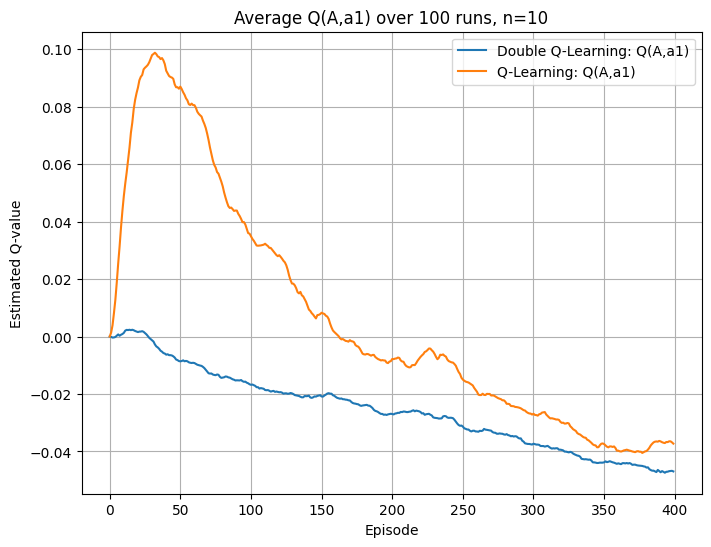

In [24]:
# -----------------------------------------------------------------------
# The MDP: States A,B and actions a1,a2,b1,...,bn (don't modify anything anymore, just run to get the graphs)
# -----------------------------------------------------------------------
@dataclass(frozen=True)
class P1State:
    """
    The MDP state, storing whether we are in "A" or "B".
    """
    name: str

class P1MDP(MarkovDecisionProcess[P1State, str]):
    
    def __init__(self, n: int):
        self.n = n

    def actions(self, state: NonTerminal[P1State]) -> Iterable[str]:
        """
        Return the actions available from this state.
          - if state is A => ["a1", "a2"]
          - if state is B => ["b1", ..., "bn"]
        """
        if state.state.name == "A":
            return ["a1", "a2"]
        else:
            return [f"b{i}" for i in range(1, self.n+1)]
    
    def step(
        self,
        state: NonTerminal[P1State],
        action: str
    ) -> Distribution[Tuple[State[P1State], float]]:
        """
        Return the distribution of (next state, reward) from (state, action):
          - A + a1 => reward 0, next state B
          - A + a2 => reward 0, next state terminal
          - B + b_i => reward ~ Normal(-0.1,1), next state terminal
        """
        if state.state.name == "A":
            if action == "a1":
                return Constant((NonTerminal(P1State("B")), 0.0))
            else:
                return Constant((Terminal(P1State("T")), 0.0))
        else:
            # For B + b_i => reward ~ N(-0.1,1), then terminal
            def sampler():
                r = np.random.normal(loc=-0.1, scale=1.0)
                return (Terminal(P1State("T")), r)
            return SampledDistribution(sampler)

def run_double_q_once(mdp, start_dist, gamma=1.0, episodes=400):
    """
    Runs one 'chain' of Double Q-Learning for 'episodes' episodes,
    returning a list of Q-values for Q((A,a1)) at the end of each episode.
    """
    dq_iter = double_q_learning(mdp, start_dist, gamma)  # generator
    vals = []
    for _ in range(episodes):
        Q1 = next(dq_iter)
        # record Q1((A,a1)) each time
        qA1 = Q1((NonTerminal(P1State("A")), "a1"))
        vals.append(qA1)
    return vals

def run_q_once(mdp, start_dist, gamma=1.0, episodes=400):
    """
    Same but for standard Q-Learning
    """
    q_iter = q_learning(mdp, start_dist, gamma)
    vals = []
    for _ in range(episodes):
        Q = next(q_iter)
        qA1 = Q((NonTerminal(P1State("A")), "a1"))
        vals.append(qA1)
    return vals

def main():
    # For reproducibility
    random.seed(0)
    np.random.seed(0)

    n = 10
    mdp = P1MDP(n)
    # Always start in A, as a NonTerminal
    start_dist = Constant(NonTerminal(P1State("A")))

    N_RUNS = 100
    N_EPISODES = 400

    all_dbl = []
    all_std = []

    for _ in range(N_RUNS):
        dbl_vals = run_double_q_once(mdp, start_dist, gamma=1.0, episodes=N_EPISODES)
        std_vals = run_q_once(mdp, start_dist, gamma=1.0, episodes=N_EPISODES)
        all_dbl.append(dbl_vals)
        all_std.append(std_vals)

    arr_dbl = np.array(all_dbl)
    arr_std = np.array(all_std)

    avg_dbl = np.mean(arr_dbl, axis=0)
    avg_std = np.mean(arr_std, axis=0)

    plt.figure(figsize=(8,6))
    plt.plot(avg_dbl, label='Double Q-Learning: Q(A,a1)')
    plt.plot(avg_std, label='Q-Learning: Q(A,a1)')
    plt.xlabel('Episode')
    plt.ylabel('Estimated Q-value')
    plt.title('Average Q(A,a1) over 100 runs, n=10')
    plt.legend()
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    main()

## Problem 8: Dice Rolling Game (Led By: Elliot Porter)

Consider the following dice game. You start with $N$ $K$-sided dice on the table, and no dice in your hand. The values on the dice faces are $\{1, 2, ..., K\}$. While you have dice remaining on the table, the game proceeds as follows:

1. **Roll all the dice on the table.**  
2. **Select a nonempty subset of the dice on the table to move to your hand.**  
   - The dice you move to your hand keep the value which they were just rolled.  
   - For example, if your hand is $\{1, 3\}$ and you roll $\{2, 2, 3, 4\}$ on the table, and you decide to move the dice with $3$ and $4$ to your hand, you will now have $\{1, 3, 3, 4\}$ in your hand.

The game ends when you have no dice on the table left to roll. Your score for the game is then calculated as the sum of the values of dice in your hand **if you have at least $C$ 1’s in your hand**, and zero otherwise. For example:
- For $N = K = 4$ and $C = 2$, the score corresponding to a hand containing $\{1, 3, 1, 4\}$ would be $9$, while the score corresponding to a hand containing $\{4, 1, 3, 4\}$ would be $0$.

Your goal is to **maximize your score** at the end of the game.

---

### Part (A): MDP Modeling

With proper mathematical notation, model this as a **Finite MDP** specifying the following:
- **States**
- **Actions**
- **Rewards**
- **State-Transition Probabilities**
- **Discount Factor**

---

### Part (B): Python Implementation

Implement this MDP in Python. If you wish, you may use the code in the git repo that you forked at the start of the course (e.g., `FiniteMarkovDecisionProcess`), but if you prefer, you can implement it from scratch or use any code you have written for the course previously (whichever is more convenient for you). You should implement this for the **general case**, specifically your MDP implementation should take as parameters $N$, $K$, $C$.

For $N = 6$, $K = 4$, $C = 1$, use the `dynamic_programming.py` library (or your own code if you chose not to implement it within the class library) to solve for the **optimal value function**, and present the following values:

1. The **expected score** of the game playing optimally, calculated using your code, not analytically.
2. The **optimal action** when rolling $\{1, 2, 2, 3, 3, 4\}$ on the first roll.

### Part (A) Answer

MDP Formulation for the Dice-Rolling Game

#### States:
We denote each state by 
$s = \bigl(r, (d_1, d_2, \ldots, d_K)\bigr)$,
where:

$r \in {0,1,\ldots,N}$ is the number of dice still on the table (i.e., not yet in the hand). $\\ \\ \\ \\$

and

$\\ \\ \\ \\$ $d_i$ is how many dice of face $i$ are currently in the hand, for each $i \in \{1,2,\ldots,K\}.$

The game begins with $(r=N,\, d_1=0,\ldots,d_K=0)$ and ends in any state with $r=0$.  

#### Actions:
When $r > 0$, we first roll the $r$ dice on the table, obtaining an outcome $\omega \in {1,\ldots,K}^r$. 
$\newline$
An action $a$ is the selection of a nonempty subset of the rolled dice to move to the hand. 
Equivalently, for each face $i$, we choose
$0 \le \Delta_i \le$ (number of dice showing face $i$ in $\omega$),
with not all $\Delta_i = 0$.

#### Rewards:
All transitions give reward 0 except when transitioning into a terminal state (with $r=0$). At $r=0$, the immediate reward is
$R = \begin{cases} \sum_{i=1}^K i \cdot d_i, & \text{if } d_1 \ge C, \ 0, & \text{otherwise}. \end{cases}$
Hence, the total discounted return is determined solely by the final state’s hand composition.

#### State-Transition Probabilities:
From a nonterminal state $(r, (d_1,\ldots,d_K))$, the next state depends on the roll outcome plus the chosen subset.
	•	The roll outcome $\omega$ follows a uniform distribution over ${1,\ldots,K}^r$, with each outcome having probability $\frac{1}{K^r}$.
	•	Given outcome $\omega$ and an action $a$ that moves $\Delta_i$ dice of face $i$ to the hand, the new state is
$(r - \sum_{i=1}^K \Delta_i, (d_1+\Delta_1, \ldots, d_K+\Delta_K))$.

#### Discount Factor:
We typically set $\gamma = 1$, since all rewards are received only at the terminal step (equivalently, one may treat it as a finite-horizon problem with no discounting).


### Part (B) Answer

In [9]:
# fill in with Python code
import itertools
from functools import lru_cache
import math

class DiceRollingMDP:
    """
    MDP for the dice-rolling game:
      - N dice total,
      - K-sided dice,
      - must have >= C copies of face=1 to score sum of all faces in hand,
      - otherwise score=0.
    Uses dynamic programming to find the optimal value and policy.
    """

    def __init__(self, N: int, K: int, C: int):
        self.N = N
        self.K = K
        self.C = C

    def state_to_key(self, r: int, dist_in_hand: tuple) -> tuple:
        """
        Utility to represent state as (r, dist_in_hand),
        where dist_in_hand is a tuple of length K, dist_in_hand[i] = how many copies of face (i+1).
        We'll do 0-based indexing for convenience in code.
        """
        return (r, dist_in_hand)

    @lru_cache(None)
    def value(self, r: int, dist_in_hand: tuple) -> float:
        """
        Returns the optimal (max) expected final score from state (r, dist_in_hand),
        under optimal decisions. We'll implement a top-down memoized approach.
        """
        # If no dice remain on the table => terminal
        if r == 0:
            # Score is either sum of faces in hand (if enough 1's),
            # or 0 otherwise:
            num_ones = dist_in_hand[0]  # face=1 is index 0
            if num_ones >= self.C:
                total_sum = 0
                for face_idx, count in enumerate(dist_in_hand):
                    face_val = face_idx + 1
                    total_sum += face_val * count
                return float(total_sum)
            else:
                return 0.0

        # Not terminal => we must roll r dice, each with K equiprobable faces.
        # We'll compute the expected best outcome over all subsets we could keep.
        # The transitions are:
        #   1) We see a roll outcome of r dice: frequencies of each face (k in {1..K}).
        #   2) We choose a nonempty subset to keep.

        # We'll sum over all possible outcomes, each with probability = 1 / K^r.
        best_ev = 0.0
        # Probability of each distinct outcome is # (combinatorial) / K^r
        # We'll do a nested loop or we can do an integer partition approach, etc.

        # But for moderate N,K, we can iterate over all r-tuples or distributions.
        # We can do a distribution approach: the set of all (x_1,...,x_K) summing to r.
        # Each distribution of dice faces has a multinomial coefficient, and probability is
        #   [multinomial(x_1..x_K)] / (K^r).
        # Then we pick the best subset from that outcome.

        # We'll define a helper to iterate over all K-tuples that sum to r:
        best_ev = 0.0
        total_prob = 0.0  # should sum to 1 eventually

        for outcome_dist in self.all_distributions(r, self.K):
            # outcome_dist[i] = how many dice showed face (i+1)
            # Probability of that specific distribution:
            #   = (r! / (x_1! x_2! ... x_K!)) * (1/K^r)
            count_factor = self.multinomial_coeff(r, outcome_dist)
            outcome_prob = count_factor / (self.K**r)
            total_prob += outcome_prob

            # Now, among all nonempty subsets of outcome_dist, find the subset that yields max E.
            # We define a function best_subset_value(...) that returns the maximum expected value
            # if we pick an allowed subset from this outcome distribution.
            # Implement this as a small dynamic or direct search:
            best_subset_ev = self.best_subset_value(outcome_dist, r, dist_in_hand)

            best_ev += outcome_prob * best_subset_ev

        return best_ev

    def best_subset_value(self, outcome_dist, r, dist_in_hand):
        """
        Given that we rolled outcome_dist (K-length tuple) from r dice,
        we can pick any nonempty subset. 'Picking a subset' means we choose some 0 <= add_i <= outcome_dist[i]
        for each i, not all add_i=0 simultaneously.

        We'll try all subsets, combine them with dist_in_hand to form next state's dist,
        then call self.value(...) for that new state. We pick the subset that yields the max.

        Return the maximum expected value from that choice.
        """

        # We'll do a simple complete search (there could be up to 2^r subsets, but typically we do
        # a distribution approach that might be large if r is big. For moderate r, it's still feasible.
        # For a large r, we might do a separate approach or prune.

        # But since outcome_dist is a distribution among K faces, the number of distinct subsets is
        # all ways to choose 0..x_i from each face i, except the case of picking nothing.

        best_val = 0.0

        def backtrack(i, subset_dist):
            nonlocal best_val
            if i == self.K:
                # check if subset_dist is nonempty
                if any(x > 0 for x in subset_dist):
                    # build new dist_in_hand
                    new_dist = tuple(dist_in_hand[j] + subset_dist[j] for j in range(self.K))
                    used = sum(subset_dist)
                    # new r is r - used
                    new_r = r - used
                    candidate_val = self.value(new_r, new_dist)
                    if candidate_val > best_val:
                        best_val = candidate_val
                return
            # we can pick from 0 up to outcome_dist[i] copies of face i, then move to i+1
            for add_count in range(outcome_dist[i] + 1):
                subset_dist[i] = add_count
                backtrack(i+1, subset_dist)
            subset_dist[i] = 0  # reset

        # We'll store picks in subset_dist array
        subset_dist = [0]*self.K
        backtrack(0, subset_dist)
        return best_val

    @staticmethod
    def all_distributions(total, k):
        """
        Generate all k-tuples of nonnegative integers summing to 'total'.
        E.g. for total=3,k=2 => (3,0),(2,1),(1,2),(0,3).
        """
        # simple recursive or iterative approach
        if k == 1:
            yield (total,)
        else:
            for x in range(total+1):
                for tail in DiceRollingMDP.all_distributions(total - x, k-1):
                    yield (x,)+tail

    @staticmethod
    def multinomial_coeff(n, counts):
        """
        Return n! / (counts[0]! * counts[1]! * ...). Standard combinatorial formula.
        """
        # can do math.factorial(n)//(factorial(...)...) or so
        # For speed, we can do directly:
        from math import comb
        # n! / (x_1! x_2! ... x_k!)
        res = math.factorial(n)
        for c in counts:
            res //= math.factorial(c)
        return res


# -------------------------------------------------------------------

# For testing purposes, solve for N=6, K=4, C=1
def solve_dice_game_example(N=6, K=4, C=1):
    """
    Solve the dice game for N=6, K=4, C=1 using the DP approach above.
    Then:
      1) Print the expected final score (optimal).
      2) Print the best subset to keep if the first roll is {1,2,2,3,3,4}.
    """
    mdp = DiceRollingMDP(N, K, C)
    
    # (A) Compute the expected final score from the start state => (r=6, dist_in_hand=(0,0,0,0))
    # Because we have 0 dice in the hand initially, and all 6 on the table.
    initial_dist = (0,0,0,0)  # for K=4
    init_val = mdp.value(6, initial_dist)
    print(f"Optimal expected final score (N=6, K=4, C=1) = {init_val:.4f}")

    # (B) We want the best action for the *specific first roll* {1,2,2,3,3,4}.
    # We'll interpret that as outcome_dist: how many 1's,2's,3's,4's we got?
    # In that multiset, we see: 1 =>1 time, 2 =>2 times, 3 =>2 times, 4 =>1 time.
    outcome_dist = (1,2,2,1)  # face=1 =>1, face=2 =>2, face=3 =>2, face=4 =>1
    r = 6  # we had 6 dice on the table
    dist_in_hand = (0,0,0,0)  # none in hand prior to this roll

    # We'll replicate the subset-choosing logic from best_subset_value:
    # but also store which subset yields the max:
    best_subset_dist = None
    best_value = -1.0

    def backtrack(i, subset_dist):
        nonlocal best_subset_dist, best_value
        if i == K:
            # check if subset_dist is nonempty
            if any(x > 0 for x in subset_dist):
                new_dist = tuple(dist_in_hand[j] + subset_dist[j] for j in range(K))
                used = sum(subset_dist)
                new_r = r - used
                val = mdp.value(new_r, new_dist)
                if val > best_value:
                    best_value = val
                    best_subset_dist = tuple(subset_dist)
            return
        for add_count in range(outcome_dist[i] + 1):
            subset_dist[i] = add_count
            backtrack(i+1, subset_dist)
        subset_dist[i] = 0

    K=4
    subset_dist = [0]*K
    backtrack(0, subset_dist)

    # Print results
    print(f"Optimal value if first roll is 1,2,2,3,3,4: {best_value:.4f}")
    print("The best subset to keep from that roll is:", best_subset_dist,
          "(face=1,2,3,4 respectively)")

if __name__ == "__main__":
    solve_dice_game_example()

Optimal expected final score (N=6, K=4, C=1) = 18.3904
Optimal value if first roll is 1,2,2,3,3,4: 18.3767
The best subset to keep from that roll is: (0, 0, 0, 1) (face=1,2,3,4 respectively)


Expected Score: 18.3904

Optimal Action: Given the first roll ${1,2,2,3,3,4}$, the best choice is to keep only the single “4,” i.e. $(\Delta_1,\Delta_2,\Delta_3,\Delta_4)=(0,0,0,1)$ and re-roll the remaining five dice, leading to an overall expected final total of about 18.3767 from there.